In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import arviz as az
import dill

# JAX
import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import optax


# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

from model import VGAEOutput

#plt.style.use('bmh')

/Users/salmanfaris/miniforge3/envs/prior-vgae-zimbabwe/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
RNG_KEY = jax.random.PRNGKey(3)

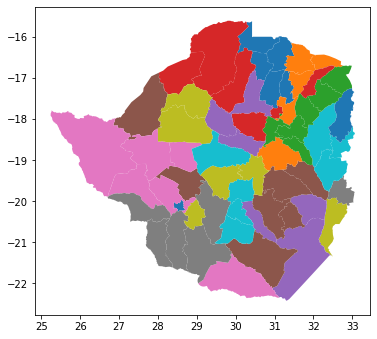

In [4]:
from pathlib import Path
data_path = Path('./dataset.nosync/zwe2016phia.geojson')

df = gpd.read_file(data_path)

_, ax = plt.subplots(figsize=(6, 6))
df.plot(column='area_id', ax=ax)
plt.show()

In [5]:
df.columns

Index(['indicator', 'survey_id', 'survey_mid_calendar_quarter', 'area_id',
       'area_name', 'res_type', 'sex', 'age_group', 'n_clusters',
       'n_observations', 'n_eff_kish', 'estimate', 'std_error', 'ci_lower',
       'ci_upper', 'y', 'n_obs', 'iso3', 'area_level', 'parent_area_id',
       'spectrum_region_code', 'area_sort_order', 'center_x', 'center_y',
       'area_level_label', 'display', 'spectrum_level', 'epp_level',
       'naomi_level', 'pepfar_psnu_level', 'geometry'],
      dtype='object')

In [6]:
df = df[[
    'area_id',
    'geometry',
    'y',
    'n_obs',
    'estimate',
]]

df['y'] = round(df.y).astype(int)
df['n_obs'] = round(df.n_obs).astype(int)

print(f'Number of NaNs in n_obs = {np.sum(np.isnan(df.n_obs))}')

Number of NaNs in n_obs = 0


/Users/salmanfaris/miniforge3/envs/prior-vgae-zimbabwe/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


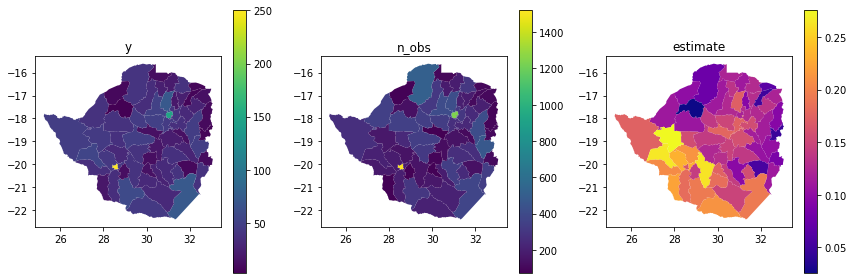

In [7]:
_, ax = plt.subplots(1, 3, figsize=(12, 4))
df.plot(column='y', ax=ax[0], legend=True)
df.plot(column='n_obs', ax=ax[1], legend=True)
df.plot(column='estimate', ax=ax[2], cmap='plasma', legend=True)

ax[0].set_title('y')
ax[1].set_title('n_obs')
ax[2].set_title('estimate')

plt.tight_layout()
plt.show()

In [8]:
polygons = df['geometry'].copy()
A = polygons.geometry.apply(lambda g: polygons.intersects(g))
A = np.array(A * 1)
A = A - np.eye(A.shape[0])

assert np.all(A.sum(axis=0) == A.sum(axis=1))
d = A.sum(axis=0)

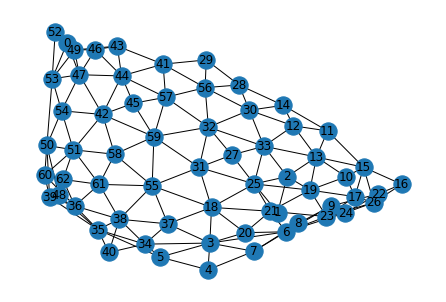

In [9]:
import networkx as nx
g = nx.from_numpy_matrix(A)
nx.draw(g, with_labels=True)

In [10]:
from dataclasses import dataclass
from typing import Dict, Optional

Params = Dict[str, Dict[str, jnp.ndarray]]

@dataclass
class CARArgs:
  adj_matrix: np.ndarray = A
  degree_vector: jnp.ndarray = d
  n_obs_vector: jnp.ndarray = jnp.array(df.n_obs)
  num_regions: int = len(polygons)
  
  decoder_params: Optional[Params] = None
  scaler: Optional[callable] = None
  
CAR_ARGS = CARArgs()

# Creating dataset

In [11]:
def car_predictive_model(args: CARArgs) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)

  alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))

  Q_std = (D - alpha*A)
  numpyro.sample('car_std', dist.MultivariateNormal(loc=jnp.zeros(args.num_regions), precision_matrix=Q_std))

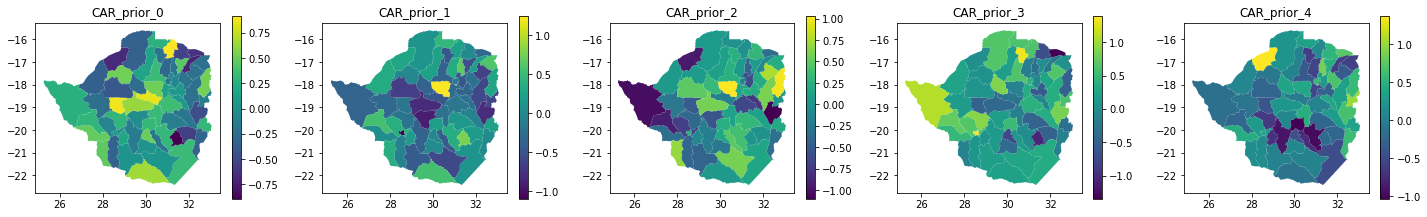

In [12]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

num_to_plot = 5
car_preds = Predictive(car_predictive_model, num_samples=num_to_plot)(rng_pred, CAR_ARGS)
car_draws = car_preds['car_std']

_, axes = plt.subplots(1, num_to_plot, figsize=(20, 3))

df_plot_samples = df.copy()
for i in range(5):
    title = f'CAR_prior_{i}'
    df_plot_samples[title] = car_draws[i]
    df_plot_samples.plot(column=title, ax=axes[i], legend=True)
    axes[i].set_title(title)
    
plt.tight_layout()
plt.show()

In [13]:
import dataset

def generate_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 1,
        model_args: CARArgs = CAR_ARGS) -> jnp.ndarray:
    car_preds = Predictive(
        car_predictive_model, num_samples=batch_size)(rng, model_args)
    car_draws = car_preds['car_std']  # (batch_size, num_regions)
    return car_draws

# VGAE-CAR

In [14]:
from dataclasses import dataclass
import loss
from typing import Callable, NamedTuple

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

# class Args(NamedTuple):
#   loss_fn: LossFun = loss.compute_mse_loss
#   num_nodes: int = A.shape[0]  
#   batch_size: int = 1
#   scale: int = 3.0
  
#   act_fn = jax.nn.leaky_relu
#   hidden_dim: int = 20
#   latent_dim: int = 20
#   output_dim: int = 1
  
#   learning_rate: float = 1e-3
#   epochs: int = 200_000
  
#   eval_frequency: int = 5000

@dataclass
class Args:  
  # Training params
  loss_fn: LossFun = loss.compute_mse_loss
  epochs: int = 200_000
  eval_frequency: int = 1000
  learning_rate: float = 1e-2
  beta: float = 1e-3  # beta-VAE
  
  # Model params
  hidden_gnn_dim: int = 10
  hidden_fc_dim: int = 63
  latent_dim: int = 50
  output_dim: int = 1
  act_fn: Callable = jax.nn.elu  

ARGS = Args()
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x287ade550>, epochs=400000, eval_frequency=1000, learning_rate=0.01, beta=0.001, hidden_gnn_dim=10, hidden_fc_dim=63, latent_dim=50, output_dim=1, act_fn=<CompiledFunction of <function elu at 0x179927310>>)


In [15]:
from pathlib import Path
train_path = Path.cwd() / 'dataset.nosync/zimbabwe_car_train_data.npy'
val_path = Path.cwd() / 'dataset.nosync/zimbabwe_car_val_data.npy'

OVERRIDE_SAVE = False

RNG_KEY, train_rng, val_rng = jax.random.split(RNG_KEY, 3)
if (train_path.exists() and val_path.exists()) and not OVERRIDE_SAVE:
    train_data = jnp.array(np.load(train_path))
    val_data = jnp.array(np.load(val_path))
else:
    train_data = generate_car_batch(train_rng, batch_size=200_000)
    val_data = generate_car_batch(val_rng, batch_size=200_000)
    np.save(train_path, np.asarray(train_data))
    np.save(val_path, np.asarray(val_data))

In [16]:
train_data = jnp.concatenate((train_data, val_data[:195_000]))
val_data = val_data[195_000:]

In [17]:
from preprocess import LinearScaler, NoScaler

# DO NOT APPLY SCALING, JUST USE BETA
scaler = NoScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

BASE_GRAPH = dataset.create_grid_graph(CAR_ARGS.adj_matrix)
scaled_graph_train_data = [
    BASE_GRAPH._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_train_data
]
scaled_graph_val_data = [
    BASE_GRAPH._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_val_data
]

CAR_ARGS.scaler = scaler

In [18]:
from typing import Tuple
from model import VGAEOutput
import layer

class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        output_dim: int,
        num_nodes: int,
    ):
        super().__init__()
        self._hidden_gnn_dim = hidden_gnn_dim
        self._hidden_fc_dim = hidden_fc_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim
        self._num_nodes = num_nodes
        self.act = ARGS.act_fn

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean, log_std = encoder(
            graph,
            self._hidden_gnn_dim,
            self._hidden_fc_dim,
            self._latent_dim,
            self._num_nodes,
            self.act,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = decoder(
            z,
            self._hidden_fc_dim,
            self._hidden_gnn_dim,
            self._output_dim,
            self._num_nodes,
            self.act
        )

        return VGAEOutput(mean, log_std, output)

def encoder(
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        num_nodes: int,
        act_fn: Callable = jax.nn.elu) -> Tuple[jnp.ndarray, jnp.ndarray]:
    
    # Graph layer
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=False,
    )
    graph = gn(graph)
    # graph = layer.GraphwiseLayerNorm()(graph)
    
    x = graph.nodes.reshape(1, num_nodes, hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (1, num_nodes*hidden_gnn_dim)

    # x = hk.Linear(hidden_fc_dim)(x)
    # x = act_fn(x)
    
    # No activation
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def decoder(
        z: jnp.ndarray,
        hidden_fc_dim: int,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    # z = hk.Linear(hidden_fc_dim, name='decoder_hidden_fc')(z)
    # z = act_fn(z)
    
    z = hk.Linear(num_nodes*hidden_gnn_dim,
                  name='decoder_hidden2_fc')(z)  # (1, num_nodes*hidden_gnn_dim)
    z = act_fn(z)
    
    # Reshape to jraph.batch format: (num_nodes, hidden_gnn_dim)
    z = z.reshape((num_nodes, hidden_gnn_dim))
    # graph = BASE_GRAPH._replace(nodes=z)
    graph = BASE_GRAPH._replace(nodes=z)
    
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn'), act_fn,
        ]),
        add_self_edges=False,
    )
    graph = gn(graph)
    # graph = layer.GraphwiseLayerNorm()(graph)
    
    # Layer normalization
    # NOTE :- Layer normalization on the decoder yields a shrinked GP.
    # graph = layer.GraphwiseLayerNorm()(graph)
    
    # No activation
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Linear(output_dim, name='decoder_output'),
        add_self_edges=False,
    )
    graph = gn(graph)

    return graph

In [19]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_gnn_dim=ARGS.hidden_gnn_dim,
                 hidden_fc_dim=ARGS.hidden_fc_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim,
                 num_nodes=CAR_ARGS.num_regions)(x))

# optimizer = optax.adam(ARGS.learning_rate)

scheduler = optax.exponential_decay(
    init_value=ARGS.learning_rate,
    transition_steps=1000,
    decay_rate=0.75,
)

# Combining gradient transforms using `optax.chain`
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

In [20]:
@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = (1.0/ARGS.beta)*log_likelihood - kld
  
  return -elbo, kld
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

### Initialize net and optimizer

In [21]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

init_graph = scaled_graph_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [22]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []
train_klds = []
val_klds = []

train_size = len(scaled_graph_train_data)
val_size = len(scaled_graph_val_data)

eval_counter: int = 0

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)

  train_graph_batch = scaled_graph_train_data[epoch % train_size]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
    
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss, train_kld = loss_fn(params, train_loss_rng, train_graph_batch)
    
    val_graph_batch = scaled_graph_val_data[eval_counter]
    val_loss, val_kld = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
          f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}; '
          # f'Train kld: {train_kld:.3f}; Validation kld: {val_kld:.3f}'
    )
      
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_klds.append(train_kld.item())
    val_klds.append(val_kld.item())
    
    eval_counter += 1

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x287ade550>
01:27:47 STEP: 0; Train loss: 537.809; Validation loss: 248.033; 
01:27:48 STEP: 1000; Train loss: 257.190; Validation loss: 155.071; 
01:27:49 STEP: 2000; Train loss: 212.485; Validation loss: 175.040; 
01:27:50 STEP: 3000; Train loss: 133.821; Validation loss: 161.747; 
01:27:51 STEP: 4000; Train loss: 177.502; Validation loss: 168.833; 
01:27:51 STEP: 5000; Train loss: 136.013; Validation loss: 175.020; 
01:27:52 STEP: 6000; Train loss: 139.145; Validation loss: 137.952; 
01:27:53 STEP: 7000; Train loss: 128.977; Validation loss: 142.759; 
01:27:54 STEP: 8000; Train loss: 143.619; Validation loss: 142.770; 
01:27:54 STEP: 9000; Train loss: 156.473; Validation loss: 164.792; 
01:27:55 STEP: 10000; Train loss: 127.087; Validation loss: 170.921; 
01:27:56 STEP: 11000; Train loss: 221.005; Validation loss: 179.184; 
01:27:56 STEP: 12000; Train loss: 214.390; Validation loss: 170.239; 
01:27:57 STEP: 13000; Train loss: 200.369; Validatio

In [23]:
print(eval_counter)

401


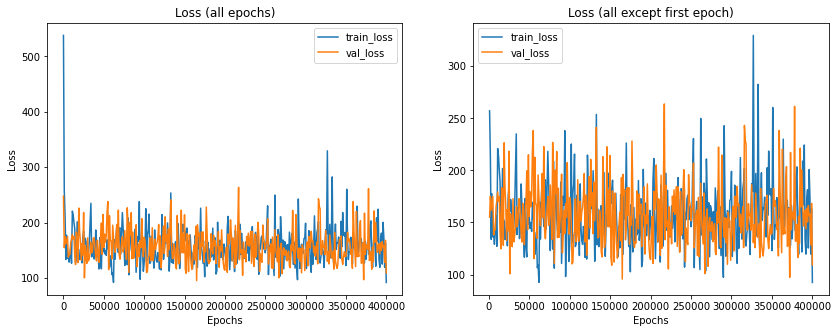

In [24]:
from matplotlib.ticker import MaxNLocator

_, axes = plt.subplots(1, 2, figsize=(14, 5))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0].plot(xs, train_losses, label='train_loss')
axes[0].plot(xs, val_losses, label='val_loss')
axes[1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0].set_title('Loss (all epochs)')
axes[1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[i].set_ylabel('Loss')
    axes[i].set_xlabel('Epochs')
    axes[i].legend()
plt.show()

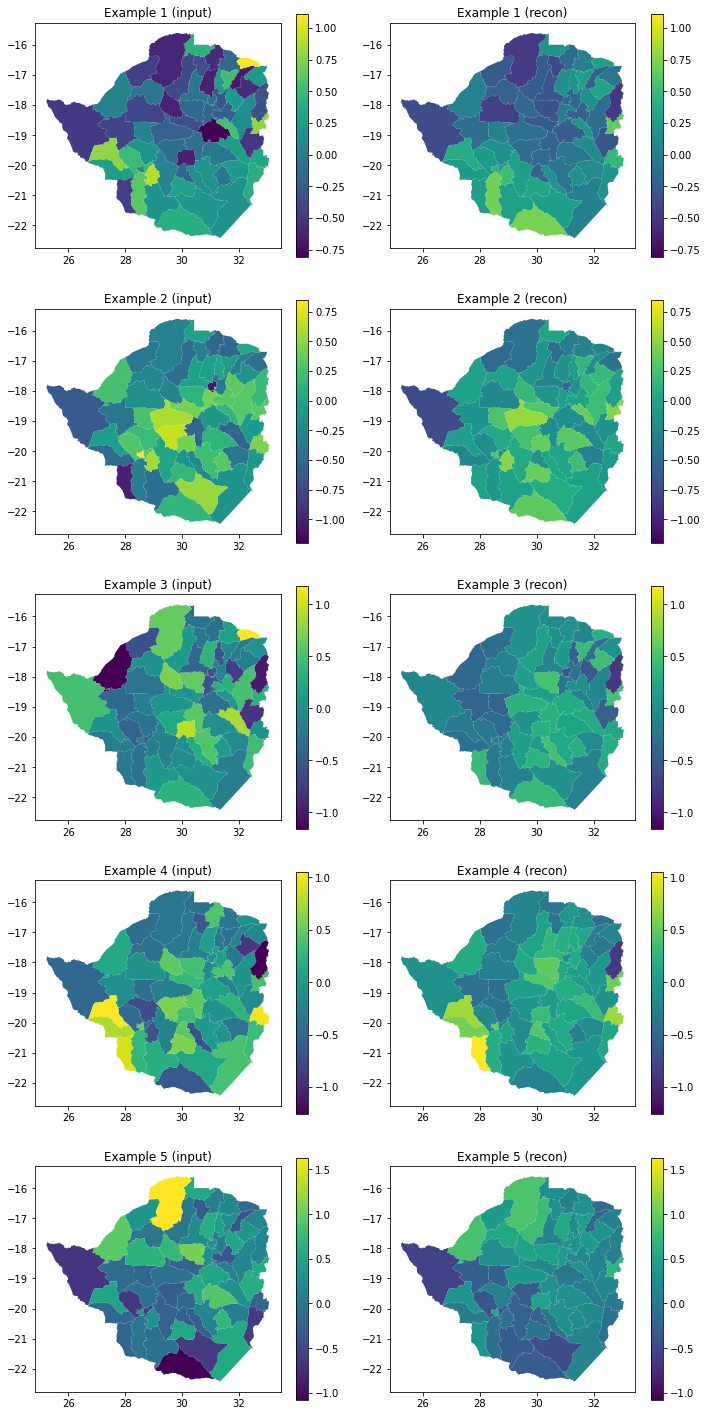

In [25]:
# Check whether the network is learning at all.

RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

num_examples = 5
fig, axes = plt.subplots(num_examples, 2, figsize=(10, 20))
for i in range(num_examples):
    original_data = val_data[i]
    scaled_data_graph = scaled_graph_val_data[i]
    outputs = net.apply(params, RNG_KEY, scaled_data_graph)

    # Unscaling
    recon_data = scaler.inverse_transform(jnp.ravel(outputs.output.nodes))

    original_image = jnp.ravel(original_data)
    recon_image = jnp.ravel(recon_data)

    # Plotting
    t = df.copy()
    title_original = f'original_{i}'
    title_recon = f'recon_{i}'
    t[title_original] = original_image
    t[title_recon] = recon_image
    
    vmin = np.amin([original_image, recon_image])
    vmax = np.amax([original_image, recon_image])
      
    t.plot(column=title_original, ax=axes[i, 0], 
           legend=True, vmin=vmin, vmax=vmax)
    t.plot(column=title_recon, ax=axes[i, 1], 
           legend=True, vmin=vmin, vmax=vmax)
    axes[i, 0].set_title(f'Example {i+1} (input)')
    axes[i, 1].set_title(f'Example {i+1} (recon)')

plt.tight_layout()
plt.show()

In [26]:
fig_path = Path('./figures/zimbabwe_figures/')
model_name = (
    f'carZ_VGAE-GCN_flattened_lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
    f'beta{ARGS.beta}_gnn{ARGS.hidden_gnn_dim}_fc{ARGS.hidden_fc_dim}_z{ARGS.latent_dim}'
)
fig_name = model_name +  '.jpg'
fig.savefig(fig_path/fig_name)

In [27]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x287ade550>, epochs=400000, eval_frequency=1000, learning_rate=0.01, beta=0.001, hidden_gnn_dim=10, hidden_fc_dim=63, latent_dim=50, output_dim=1, act_fn=<CompiledFunction of <function elu at 0x179927310>>)


In [28]:
from functools import partial

decoder_params_keys = [k for k in list(params.keys()) if k.startswith('vgae/decoder')]
decoder_params = {}
for full_key_name in decoder_params_keys:
    key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
    decoder_params[key_name] = params[full_key_name]
    
CAR_ARGS.decoder_params = decoder_params

decoder_net_fn = partial(decoder,
                         hidden_fc_dim=ARGS.hidden_fc_dim,
                         hidden_gnn_dim=ARGS.hidden_gnn_dim,
                         output_dim=ARGS.output_dim,
                         num_nodes=CAR_ARGS.num_regions)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

In [29]:
def vgae_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(CAR_ARGS.decoder_params, z).nodes)
    numpyro.deterministic('car_std', vgae_out)

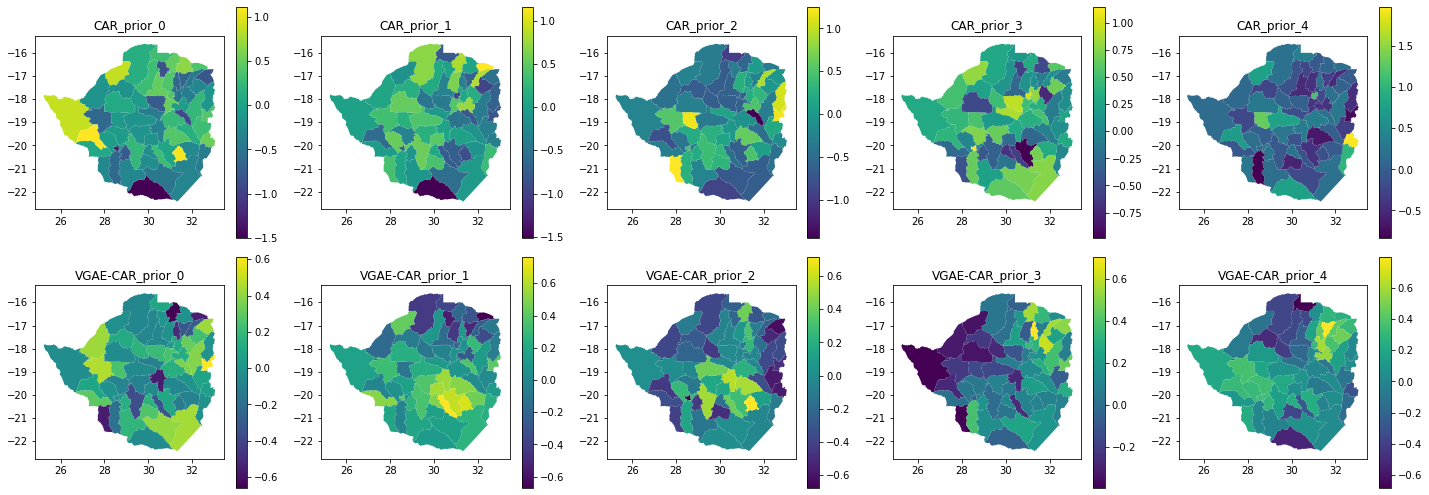

In [30]:
#Prior predictive

RNG_KEY, rng_car, rng_vgae = jax.random.split(RNG_KEY, 3)

num_to_plot = 5
car_preds = Predictive(car_predictive_model, num_samples=num_to_plot)(rng_car, CAR_ARGS)
car_draws = car_preds['car_std']

vgae_preds = Predictive(vgae_predictive_model, num_samples=num_to_plot)(rng_vgae)
vgae_draws = vgae_preds['car_std']

_, axes = plt.subplots(2, num_to_plot, figsize=(20, 7))
df_plot_samples = df.copy()
for i in range(5):
    title = f'CAR_prior_{i}'
    df_plot_samples[title] = car_draws[i]
    df_plot_samples.plot(column=title, ax=axes[0, i], legend=True)
    axes[0, i].set_title(title)
    
    title = f'VGAE-CAR_prior_{i}'
    df_plot_samples[title] = vgae_draws[i]
    df_plot_samples.plot(column=title, ax=axes[1, i], legend=True)
    axes[1, i].set_title(title)
    
plt.tight_layout()
plt.show()

# Prevalence VGAE-CAR

In [56]:
def prevalence_vgae_predictive_model(args: CARArgs, y=None) -> None:
  n_obs = args.n_obs_vector
  
  z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
  
  # The transpose is because we initially used 
  # more than one samples ~ N(0, 1) as features for each node
  out = jnp.squeeze(decoder_net.apply(args.decoder_params, z).nodes)
  car_std_vgae = numpyro.deterministic('car_std_vgae', out)
  
  # Fixed effects
  b0 = numpyro.sample('b0', dist.Normal(0, 1))
  tau = numpyro.sample('tau', dist.Gamma(6, 4)) 

  sigma = numpyro.deterministic('sigma', 1./jnp.sqrt(tau))
  car_vgae = numpyro.deterministic('car_vgae', sigma * car_std_vgae)
  _ = numpyro.deterministic('VGAE-CAR 1', car_vgae[0])

  lp = b0 + car_vgae
  numpyro.deterministic("theta", jax.nn.sigmoid(lp))
      
  numpyro.sample("obs", dist.BinomialLogits(total_count=n_obs, logits=lp), obs=y)

In [57]:
RNG_KEY, rng_mcmc_vgae = jax.random.split(RNG_KEY)

# Inference
start = time.time()
kernel = NUTS(prevalence_vgae_predictive_model)
mcmc_vgae = MCMC(
    kernel, 
    num_warmup=1000, 
    num_samples=2000,
)
mcmc_vgae.run(rng_mcmc_vgae, CAR_ARGS, y=jnp.array(df.y))
t_elapsed = time.time() - start

prevalence_vgae_samples = mcmc_vgae.get_samples()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 543.47it/s, 31 steps of size 1.61e-01. acc. prob=0.93]


In [58]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_vgae.get_samples(group_by_chain=True))
r = np.mean(ss['car_vgae']['n_eff'])
print("Average ESS for all VAE-CAR effects : " + str(round(r)))


MCMC elapsed time: 6 s
Average ESS for all VAE-CAR effects : 1722


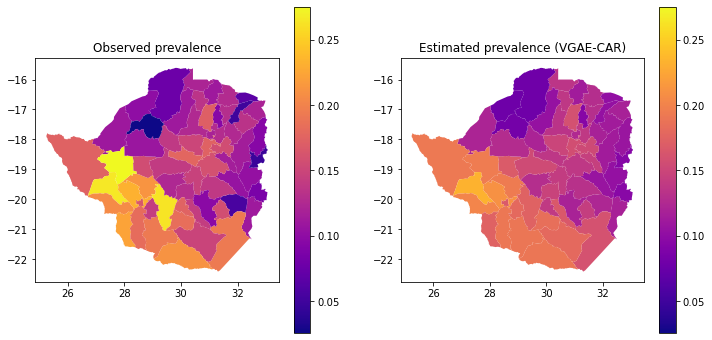

In [59]:
RNG_KEY, predictive_rng = jax.random.split(RNG_KEY)

# posterior predictive
prev_posterior_predictive_vae = Predictive(
    prevalence_vgae_predictive_model, 
    prevalence_vgae_samples)(predictive_rng, CAR_ARGS)

theta_sams_vae_car = prev_posterior_predictive_vae['theta']
theta_mean_vae_car = theta_sams_vae_car.mean(axis=0)
bci_vae_car_25 = np.quantile(theta_sams_vae_car, 0.25, axis=0)
bci_vae_car_75 = np.quantile(theta_sams_vae_car, 0.75, axis=0)

df['theta_vae_car'] = theta_mean_vae_car

theta_observed = df['estimate']
theta_estimated = df['theta_vae_car']

_max = np.max([theta_observed, theta_estimated])
_min = np.min([theta_observed, theta_estimated])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
df.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
df.plot(column="theta_vae_car", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (VGAE-CAR)')

plt.show()

mse_vgae = 0.0007403603084987916


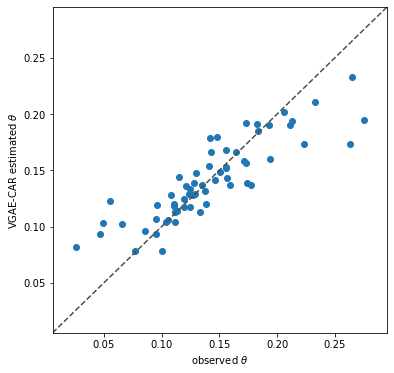

In [60]:
import plotting

vmax = np.max([theta_observed, theta_estimated])
vmin = np.min([theta_observed, theta_estimated])

plotting.plot_compare_estimates(
    data_x=theta_observed, data_y=theta_estimated,
    x_label=r'observed $\theta$', 
    y_label=r'VGAE-CAR estimated $\theta$',
    xlim=(vmin-0.02, vmax+0.02),
    ylim=(vmin-0.02, vmax+0.02),
    figsize=(6, 6),
)

mse_vgae = np.mean((theta_observed -  theta_estimated)**2)
print(f'mse_vgae = {mse_vgae}')

# Prevalence CAR

In [61]:
def prevalence_car_predictive_model(args: CARArgs, y=None) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)
  n_obs = args.n_obs_vector

  # Fixed effects
  b0 = numpyro.sample('b0', dist.Normal(0, 1))
  tau = numpyro.sample('tau', dist.Gamma(6, 4)) 
  alpha = numpyro.sample('alpha', dist.Uniform(low=0., high=1.))

  Q_std = (D - alpha*A)
  car_std = numpyro.sample('car_std', dist.MultivariateNormal(loc=jnp.zeros(args.num_regions), precision_matrix=Q_std))
  sigma = numpyro.deterministic('sigma', 1./jnp.sqrt(tau))
  car = numpyro.deterministic('car', sigma * car_std)

  numpyro.deterministic('CAR 1', car[0])

  lp = b0 + car
  numpyro.deterministic("theta", jax.nn.sigmoid(lp))
      
  numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [62]:
import dill
mcmc_path = Path.cwd() / 'models/zimbabwe_car_mcmc_sampler.pkl'

OVERRIDE_LOAD = False

RNG_KEY, mcmc_rng = jax.random.split(RNG_KEY)
start = time.time()
if mcmc_path.exists():
    # Load sampler.
    with open(mcmc_path, 'rb') as f:
        mcmc_car = dill.load(f)
else:
    kernel = NUTS(prevalence_car_predictive_model)
    mcmc_car = MCMC(kernel, num_warmup=1000, num_samples=2000)
    mcmc_car.run(mcmc_rng, CAR_ARGS, y=jnp.array(df.y))
    
    # Save sampler.
    with open(mcmc_path, 'wb') as f:
        dill.dump(mcmc_car, f)
        
prevalence_car_samples = mcmc_car.get_samples()
mcmc_car.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      CAR 1      0.14      0.18      0.16     -0.14      0.42    115.93      1.02
      alpha      0.92      0.08      0.94      0.81      1.00    472.52      1.00
         b0     -1.77      0.17     -1.78     -2.02     -1.53     98.41      1.03
     car[0]      0.14      0.18      0.16     -0.14      0.42    115.93      1.02
     car[1]      0.07      0.23      0.08     -0.30      0.43    181.30      1.01
     car[2]     -0.22      0.19     -0.20     -0.48      0.09    119.73      1.02
     car[3]     -0.33      0.23     -0.32     -0.65      0.06    161.68      1.02
     car[4]     -0.50      0.30     -0.49     -0.95     -0.00    265.22      1.01
     car[5]     -0.29      0.23     -0.28     -0.67      0.05    170.63      1.02
     car[6]     -0.28      0.21     -0.27     -0.59      0.08    146.97      1.01
     car[7]     -0.41      0.22     -0.39     -0.73     -0.04    158.47      1.01
     car[8]    

1 min 22 seconds roughly

In [63]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_car.get_samples(group_by_chain=True))
r = np.mean(ss['car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 0 s
Average ESS for all CAR effects : 194


Text(0.5, 1.0, 'Estimated prevalence (CAR model)')

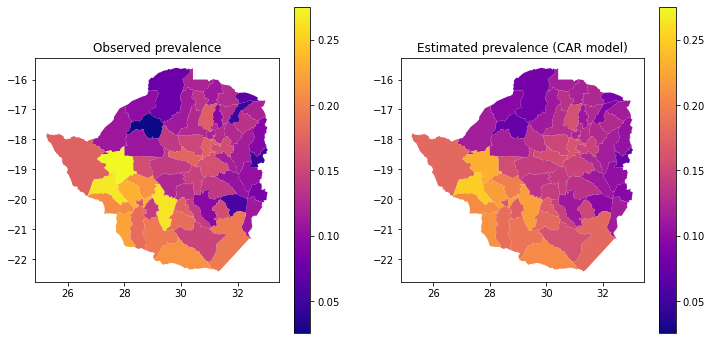

In [64]:
RNG_KEY, predictive_rng = jax.random.split(RNG_KEY)

# Posterior predictive.
prev_posterior_predictive = Predictive(
    prevalence_car_predictive_model, prevalence_car_samples)(predictive_rng, CAR_ARGS)

theta_samps_car = prev_posterior_predictive['theta']
theta_mean_car = theta_samps_car.mean(axis=0)
bci_car_25 = np.quantile(theta_samps_car, 0.25, axis=0)
bci_car_75 = np.quantile(theta_samps_car, 0.75, axis=0)

df['theta_car'] = theta_mean_car

theta_observed = df['estimate']
theta_estimated_car = df['theta_car']

_max = np.max([theta_observed, theta_estimated_car])
_min = np.min([theta_observed, theta_estimated_car])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
df.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
df.plot(column="theta_car", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (CAR model)')

mse_car = 0.00023834566416662024


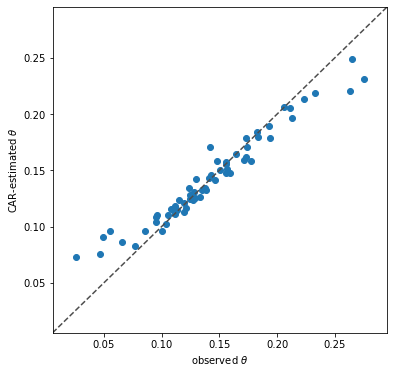

In [65]:
import plotting

vmin = np.min([theta_observed, theta_estimated_car])
vmax = np.max([theta_observed, theta_estimated_car])

plotting.plot_compare_estimates(
    data_x=theta_observed, data_y=theta_estimated_car,
    x_label=r'observed $\theta$', 
    y_label=r'CAR-estimated $\theta$',
    xlim=(vmin-0.02, vmax+0.02),
    ylim=(vmin-0.02, vmax+0.02),
    figsize=(6, 6),
)

mse_car = np.mean((theta_observed -  theta_estimated_car)**2)
print(f'mse_car = {mse_car}')

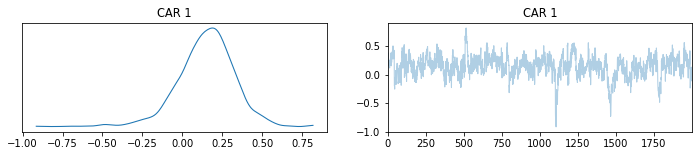

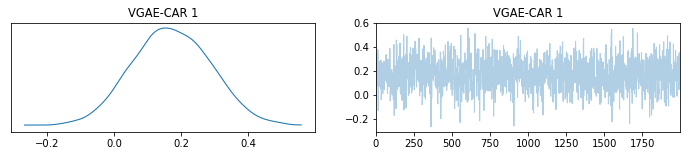

In [66]:
prevalance_car_samples_az = az.from_numpyro(mcmc_car)
az.plot_trace(prevalance_car_samples_az,  var_names=("CAR 1"))

prevalance_vgae_samples_az = az.from_numpyro(mcmc_vgae)
az.plot_trace(prevalance_vgae_samples_az,  var_names=("VGAE-CAR 1"))

plt.show()

Text(0, 0.5, 'Parameter estimate')

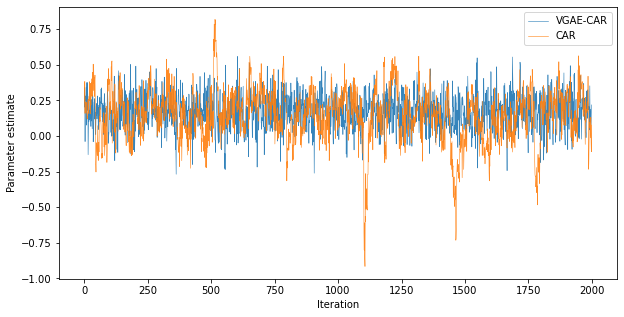

In [67]:
vgaecar0_samps = prev_posterior_predictive_vae['VGAE-CAR 1']
n_samps = vgaecar0_samps.shape[0]
car0_samps = prev_posterior_predictive['CAR 1']
n_samps = car0_samps.shape[0]

import pandas as pd
df_plt = pd.DataFrame({'VGAE-CAR':vgaecar0_samps, 'CAR': car0_samps})
df_plt.head()
df_plt.plot(lw = 0.6, alpha=0.9, figsize=(10, 5))
plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("Parameter estimate")
#plt.show()

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig("../res/Zimbabwe_traceplots.pdf")

Text(0.5, 1.0, 'Estimated prevalence (VGAE-CAR)')

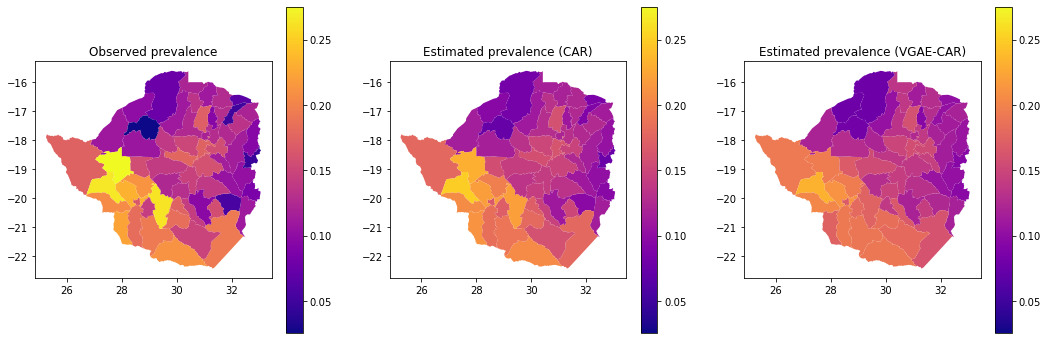

In [53]:
_max = np.max([df['estimate'], df['theta_car'], df['theta_vae_car']])
_min = np.min([df['estimate'], df['theta_car'], df['theta_vae_car']])

fig, ax = plt.subplots(1, 3, figsize=(18,6))
df.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
df.plot(column="theta_car", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
df.plot(column="theta_vae_car", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (CAR)')
ax[2].set_title( 'Estimated prevalence (VGAE-CAR)')

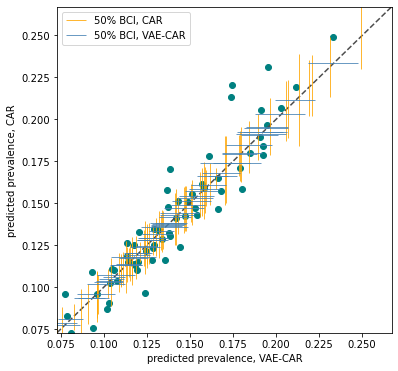

In [54]:
_max = np.max([ theta_mean_vae_car, theta_mean_car, bci_car_25, bci_car_75, bci_vae_car_25, bci_vae_car_75])
_min = np.min([ theta_mean_vae_car, theta_mean_car])

plt.rcParams["figure.figsize"] = (6,6)

plt.ylim(_min, _max)
plt.xlim(_min, _max)
plt.plot([_min, _max], [_min, _max], ls="--", c=".3")
plt.xlabel("predicted prevalence, VAE-CAR")
plt.ylabel("predicted prevalence, CAR")

plt.vlines(x=theta_mean_car, 
           ymin=bci_car_25,
           ymax=bci_car_75,
           color="orange", 
           label="50% BCI, CAR", 
           linewidth=0.8)
plt.hlines(y=theta_mean_vae_car, 
           xmin=bci_vae_car_25,
           xmax=bci_vae_car_75,
           color="steelblue", 
           label="50% BCI, VAE-CAR", 
           linewidth=0.8)

plt.scatter(theta_mean_vae_car, theta_mean_car, color="teal")
plt.legend(loc="upper left")


In [55]:
print(f'{mse_car}')
print(f'{mse_vgae}')

0.00023834566416662024
0.0007357913155444229
